In [ ]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy
import os
import pandas as pd
import cftime
import datetime as dt
import tqdm
import netCDF4 as nc
import glob

import subprocess
import cftime

In [ ]:
calendar_type = 'proleptic_gregorian'
# calendar_type = 'standard'

In [ ]:
# testing stuff 
tmpfile = '/localdrive/drive6/erai/slp/slp.1979.nc'
tmpfile = '/localdrive/drive6/erai/converts/prw.2008.nc'
x = subprocess.check_output(['ncdump', '-h', f'{tmpfile}'])
print(x.decode('ascii'))
ds = xr.open_dataset(tmpfile)
ds.prw.isel(time=50).plot()

In [ ]:
# print(subprocess.check_output(['ls', '/localdrive/drive6/erai/converts']).decode('ascii'))

In [5]:
# read in ERA-I all year SLP data (6-hr)
# all years of SLP should be given in one file...
in_folder = '/localdrive/drive6/era5/data/six_hrly/data_1deg'
# invariants = '/localdrive/drive6/era5/data/six_hrly/data_1deg/msl'

# Creating the VAR file that contains all the necessary years

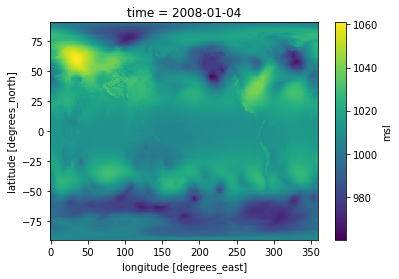

In [34]:
# start year to end year+1
year_range = [2008, 2013]
num_years = year_range[1] - year_range[0]

# var map, variable name in code to the input variable name
in_var_fn_map = {'slp': 'msl', 'tp': 'tp', 'w500': 'w500', 'tcwv': 'tcwv'}
in_var_map = {'slp': 'msl', 'tp': 'tp', 'w500': 'w', 'tcwv': 'tcwv'}
in_var_scale = {'slp': 1.0/100., 'tp': 100.*10./6.0, 'w500': 1.0, 'tcwv': 1.0}
in_var_offset = {'slp': 0.0, 'tp': 0.0, 'w500': 0.0, 'tcwv': 0.0}

# var map, variable name in code to the output variable name
out_var_map = {'slp': 'SLP', 'tp': 'PRECT', 'w500': 'W500', 'tcwv': 'PRW'}
out_var_long_name = {'slp': 'Sea Level Pressure', 'tp': 'Total Precipitation', 'w500': 'Vertical Velocity at 500hPa', 'tcwv': 'Total Column Water Vapor'}
out_var_units = {'slp': 'mb', 'tp': 'mm/hr', 'w500': 'Pa/s', 'tcwv': 'mm/hr'}

var = 'slp'
file = f"{in_folder}/{in_var_fn_map[var]}/{in_var_fn_map[var]}_2008_6hrly.nc"
ds = xr.open_dataset(file)
ds[in_var_map[var]] = ds[in_var_map[var]]*(in_var_scale[var]) + in_var_offset[var]
ds[in_var_map[var]].isel(time=12).plot()
ds.close()

In [35]:
# getting the time dimension length
time_dim = 0
var = 'slp'
for i_year, year in enumerate(range(year_range[0], year_range[1])):
    in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
    ds = xr.open_dataset(in_file)
    time_dim += len(ds.time)
    lat_dim = len(ds.latitude)
    lon_dim = len(ds.longitude)
    ds.close()
    
print(f"Dimension: (time x lat x lon) --> {time_dim} x {lat_dim} x {lon_dim}")

Dimension: (time x lat x lon) --> 7308 x 181 x 360


In [36]:
print(out_var_map)

{'slp': 'SLP', 'tp': 'PRECT', 'w500': 'W500', 'tcwv': 'PRW'}


In [37]:
# Running the code for the variable list
var_list = ['w500']

for var in var_list:
    
    # initiallizing the variable output sizes
    out_var = np.empty((time_dim, lat_dim, lon_dim))
    out_time = np.zeros((time_dim,))
    out_time_bnds = np.zeros((time_dim, 2))
    out_date = np.empty(out_time.shape, dtype=int)
    
    tmp_time_dim = 0
   
    # looping through all the years to create the single file that has all the necessary years
    for i_year, year in tqdm.tqdm_notebook(enumerate(range(year_range[0], year_range[1])), total=num_years, desc=f"{var.upper()}"): 
        in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
        if (not os.path.exists(in_file)):
            raise Exception('No file found.') 
        ds = xr.open_dataset(in_file)
        in_lat = ds.variables['latitude'].values
        in_lon = ds.variables['longitude'].values
        in_var = ds.variables[in_var_map[var]].values
        curr_time_dim = len(ds.time)
        ds.close()
        
        in_time = (np.arange(0, curr_time_dim, 1) + tmp_time_dim)*6.
        tmp_date = [dt.datetime(year_range[0], 1, 1) + dt.timedelta(hours=i_time) for i_time in in_time]
        in_date = [int(f"{i_date.year:04d}{i_date.month:02d}{i_date.day:02d}") for i_date in tmp_date]
        
        # selecting only the first 1460 to match the model output which is of a 365 year calendar
        out_date[tmp_time_dim:tmp_time_dim+curr_time_dim] = in_date
        out_time[tmp_time_dim:tmp_time_dim+curr_time_dim] = in_time
        out_var[tmp_time_dim:tmp_time_dim+curr_time_dim, :, :] = in_var
        tmp_time_dim += curr_time_dim
        
    # getting the output variables
    out_lat = in_lat
    out_lon = in_lon

    # getting the output time bounds
    out_time_bnds[:, 1] = out_time
    out_time_bnds[0, 0] = out_time[0]
    out_time_bnds[1:, 0] = out_time[:-1]
    
    # out file 
    out_file = f"/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.EXP1.DEG10.001/6hr/ERA5.EXP1.DEG10.001.{out_var_map[var]}.6hr.nc"
    out_ds = xr.Dataset({
        'time_bnds': (('time', 'nbnd'), out_time_bnds), 
        'date': (('time'), out_date),
        out_var_map[var]: (('time', 'lat', 'lon'), out_var), 
    }, 
    coords={
        'time': out_time, 
        'lat': out_lat, 
        'lon': out_lon,
        'nbnd': [1, 2]
    },
    )

    # lon attribs
    out_ds.lon.attrs['long_name'] = 'longitude'
    out_ds.lon.attrs['units'] = 'degrees_east'

    # lat attribs
    out_ds.lat.attrs['long_name'] = 'latitude'
    out_ds.lat.attrs['units'] = 'degrees_north'

    # time attribs
    out_ds.time.attrs['long_name'] = 'time'
    out_ds.time.attrs['units'] = f"hours since {year_range[0]}-01-01 00:00:00"
    out_ds.time.attrs['calendar'] = calendar_type
    out_ds.time.attrs['bounds'] = 'time_bnds'

    # time_bnds attribs
    out_ds.time_bnds.attrs['long_name'] = 'time interval endpoints'

    # date attribs
    out_ds.date.attrs['long_name'] = 'current date (YYYYMMDD)'

    # slp attribs
    out_ds[out_var_map[var]].attrs['long_name'] = out_var_long_name[var]
    out_ds[out_var_map[var]].attrs['units'] = out_var_units[var]

    out_ds.to_netcdf(out_file)
    out_ds.close()

/home/jj/anaconda3/envs/mcms/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


[20080101 20080101 20080101 ... 20121231 20121231 20121231]


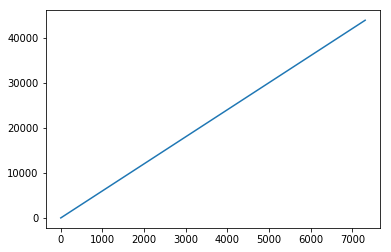

In [24]:
plt.plot(out_time)
print(out_date)

In [25]:
print(calendar_type)

proleptic_gregorian


# Testing the input model 

In [26]:
fn = '/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.EXP1.DEG10.001/6hr/ERA5.EXP1.DEG10.001.SLP.6hr.nc'
# fn = '/localdrive/drive10/jj/mdtf/inputdata/model/QBOi.EXP1.AMIP.001/6hr/QBOi.EXP1.AMIP.001.SLP.6hr.nc'
# fn = '/localdrive/drive10/jj/mdtf/inputdata/model/LEOC.EXP1.MPM.001/6hr/LEOC.EXP1.MPM.001.SLP.6hr.nc'
ncid = nc.Dataset(fn)
lat = ncid['lat'][:]
lon = ncid['lon'][:]
time = ncid['time'][:]
calendar = ncid['time'].getncattr('calendar')
time_bnds = ncid['time_bnds'][:]
ncid.close()
print(calendar, time)

proleptic_gregorian [0.0000e+00 6.0000e+00 1.2000e+01 ... 4.3830e+04 4.3836e+04 4.3842e+04]


In [28]:
ds = xr.open_dataset(fn)
print(ds.time)
ds.close()

y = [pd.to_datetime(i) for i in ds.time.values]
years = np.array([i.year for i in y])
print(years[1464])

<xarray.DataArray 'time' (time: 7308)>
array(['2008-01-01T00:00:00.000000000', '2008-01-01T06:00:00.000000000',
       '2008-01-01T12:00:00.000000000', ..., '2012-12-31T06:00:00.000000000',
       '2012-12-31T12:00:00.000000000', '2012-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2012-12-31T18:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
2009


In [29]:
print(time_bnds[1, :])
print('{:.4f}'.format((time[-1])))
print(time)

[0. 6.]
43842.0000
[0.0000e+00 6.0000e+00 1.2000e+01 ... 4.3830e+04 4.3836e+04 4.3842e+04]


In [30]:
ds = xr.open_dataset(fn)
print(ds.variables['time'])
time = ds.variables['time'].values
ind = 365*8 + (31+27)*8
print(time[ind:ind+10])

<xarray.IndexVariable 'time' (time: 7308)>
array(['2008-01-01T00:00:00.000000000', '2008-01-01T06:00:00.000000000',
       '2008-01-01T12:00:00.000000000', ..., '2012-12-31T06:00:00.000000000',
       '2012-12-31T12:00:00.000000000', '2012-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:  time
    bounds:     time_bnds
['2010-04-26T00:00:00.000000000' '2010-04-26T06:00:00.000000000'
 '2010-04-26T12:00:00.000000000' '2010-04-26T18:00:00.000000000'
 '2010-04-27T00:00:00.000000000' '2010-04-27T06:00:00.000000000'
 '2010-04-27T12:00:00.000000000' '2010-04-27T18:00:00.000000000'
 '2010-04-28T00:00:00.000000000' '2010-04-28T06:00:00.000000000']


In [31]:
print(ds.time[0])

<xarray.DataArray 'time' ()>
array('2008-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2008-01-01
Attributes:
    long_name:  time
    bounds:     time_bnds
